In [61]:
import numpy as np 
import pandas as pd
import math as math

import keras
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dense, Dropout, Flatten
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
import csv
from tqdm import tqdm_notebook as tqdm


                            Unnamed: 0    id
                                 count count
breed                                       
basset                              65    65
bluetick                            68    68
collie                              69    69
german_short-haired_pointer         60    60
labrador_retriever                  67    67
weimaraner                          68    68


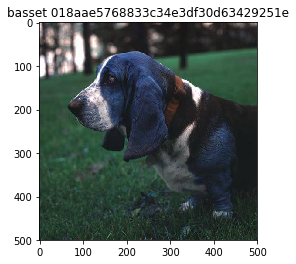

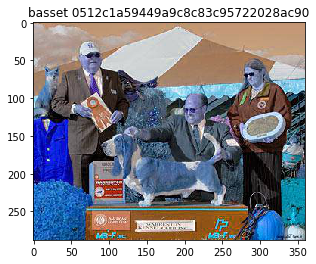

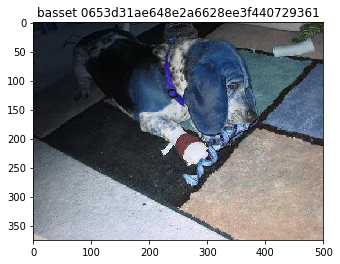

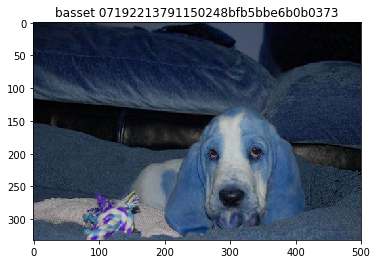

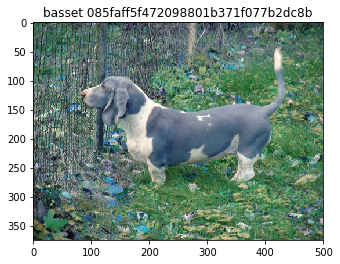

In [2]:
df_train_small = pd.read_csv("./input/labels_train_small.csv")

print(df_train_small.groupby(['breed']).agg(['count']))

for i in range(5):
    img = cv2.imread('./input/train-2/{name}.jpg'.format(name=df_train_small.id[i]))
    plt.imshow(img)
    plt.title(df_train_small.breed[i] + ' ' + df_train_small.id[i])
    plt.show()
    
def show_img(id):
    img_path = './input/train-2/{name}.jpg'.format(name=id)
    print(img_path)
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.title(id)
    plt.show()    

In [3]:


def unique_pairs(classes):
    result = []
    for c in classes:
        others = classes[classes != c]
        for o in others:
            result += [c, o]
    return np.reshape(result, (-1,2))

def construct_class_dict(df_labels, class_name, classes):
    result = {}
    for c in classes:
        labels = df_labels[df_labels[class_name] == c]
        result[c] = (labels.shape[0], labels)
    return result

def create_triplets(df_labels, classes, max_per_class):
    results = []
    class_dict = construct_class_dict(df_labels, 'breed', classes)
    #print(type(class_dict))
    pairs = unique_pairs(classes)
    a_index = 0
    p_index = a_index + 1
    for p in pairs:
        anchor = p[0]
        other = p[1]
        n_index = 0
        num_anchor, labels_anchor = class_dict.get(anchor)[0], class_dict.get(anchor)[1]
        num_other, labels_other = class_dict.get(other)[0], class_dict.get(other)[1]
        for i in range(min(num_anchor, max_per_class)):
            for j in range(min(num_other, max_per_class)):
                results += [labels_anchor.iloc[a_index]['id'], labels_anchor.iloc[p_index]['id'], labels_other.iloc[n_index]['id']]
                a_index += 1
                a_index = a_index % num_anchor
                p_index = a_index + 1
                p_index = p_index % num_anchor
                n_index += 1
                n_index = n_index % num_other
    return np.reshape(results, (-1,3))

unique_breeds = df_train_small.breed.unique()

triplets = create_triplets(df_train_small, unique_breeds, 20)

print('triplets shape: ' + str(triplets.shape))

triplets shape: (12000, 3)


M examples == 12000
144    collie
Name: breed, dtype: object
145    collie
Name: breed, dtype: object
81    bluetick
Name: breed, dtype: object
./input/train-2/1d75b0cf9ad1bd98e84bb5d0d4d3ac0f.jpg


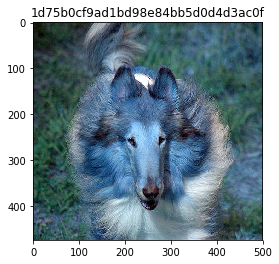

./input/train-2/1f0009002cd89d41b30791766bbf9102.jpg


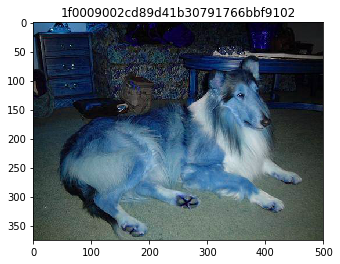

./input/train-2/3759477c2764d4e01d44d5be03b917f6.jpg


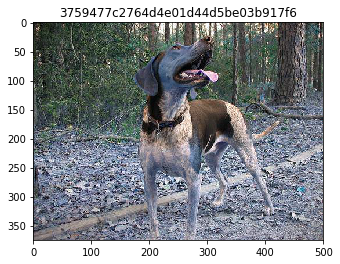

357    weimaraner
Name: breed, dtype: object
358    weimaraner
Name: breed, dtype: object
259    german_short-haired_pointer
Name: breed, dtype: object
./input/train-2/6342835fdefefa74d102b4716a151c88.jpg


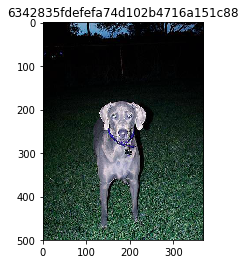

./input/train-2/660e3d56105b467159370bc1bc5e469d.jpg


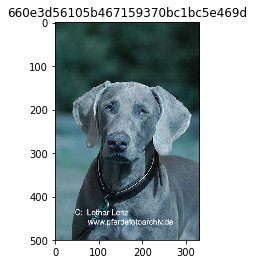

./input/train-2/d222748a1eea1d4fd0dc0c7e95c7a312.jpg


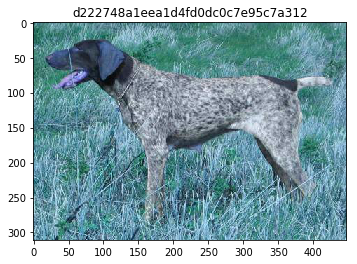

333    weimaraner
Name: breed, dtype: object
334    weimaraner
Name: breed, dtype: object
211    german_short-haired_pointer
Name: breed, dtype: object
./input/train-2/164a194e9bf8819523235879eb0c2698.jpg


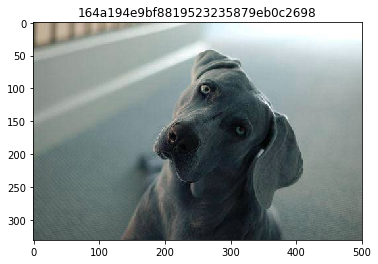

./input/train-2/22dfe796314ae40b41609f3aaca5a700.jpg


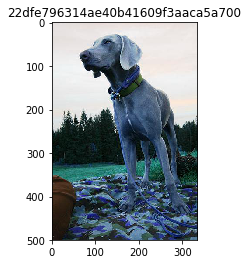

./input/train-2/24380b2177bb5243112b3c64008e2176.jpg


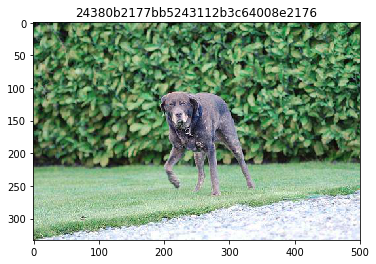

In [4]:
df_triplets = pd.DataFrame(triplets)
print('M examples == ' + str(df_triplets.shape[0]))

def show_triplets(df, s):
    print(df[df['id'] == s.iloc[0][0]]['breed'])
    print(df[df['id'] == s.iloc[0][1]]['breed'])
    print(df[df['id'] == s.iloc[0][2]]['breed'])

    show_img(s.iloc[0][0])
    show_img(s.iloc[0][1])
    show_img(s.iloc[0][2])
    return

show_triplets(df_train_small, df_triplets.sample())
show_triplets(df_train_small, df_triplets.sample())
show_triplets(df_train_small, df_triplets.sample())


In [5]:
ENCODING_SIZE = 4096

anchors = np.zeros((triplets.shape[0], 1, ENCODING_SIZE))
pos = np.zeros((triplets.shape[0], 1, ENCODING_SIZE))
negs = np.zeros((triplets.shape[0], 1, ENCODING_SIZE))

ENCODING_PATH = './input/encoding/{id}.txt'
i = 0

for row in triplets:
    anchors[i] = np.loadtxt(ENCODING_PATH.format(id=row[0]))
    pos[i] = np.loadtxt(ENCODING_PATH.format(id=row[1]))
    negs[i] = np.loadtxt(ENCODING_PATH.format(id=row[2]))
    i = i + 1
    if (i % 1000 == 0):
        print('Loaded ' + str(i) + ' triplets')


Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 4000 triplets
Loaded 5000 triplets
Loaded 6000 triplets
Loaded 7000 triplets
Loaded 8000 triplets
Loaded 9000 triplets
Loaded 10000 triplets
Loaded 11000 triplets
Loaded 12000 triplets


In [6]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

In [7]:
def doggie_encoding_model(dog=(1, ENCODING_SIZE)):
    X_input = Input(dog)
    
    X = Dense(2056, activation='sigmoid', name='fc0')(X_input)
    X = Dense(1024, activation='sigmoid', name='fc1.0')(X)
    X = Dense(1024, activation='sigmoid', name='fc1.1')(X)
    X = Dense(512, activation='sigmoid', name='fc2')(X)
    X = Dense(128, activation='sigmoid', name='fc3')(X)
    
    model = Model(inputs=X_input, outputs=X, name='doggieEncodingModel')
    
    return model
    

def doggie_breed_model(a, p, n, encoding_model):
    X0_Input = Input(a)
    X1_Input = Input(p)
    X2_Input = Input(n)

    X0 = encoding_model(X0_Input)
    X1 = encoding_model(X1_Input)
    X2 = encoding_model(X2_Input)

    model = Model(inputs = [X0_Input, X1_Input, X2_Input], outputs = [X0, X1, X2], name = 'dogBreedModel')
    
    return model

doggie_encoding_model = doggie_encoding_model()
doggie_breed_model = doggie_breed_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), doggie_encoding_model)
doggie_breed_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])


because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies

In [82]:
# doggie_encoding_model.reset_states()
# doggie_breed_model.reset_states()

y_dummies = np.zeros((triplets.shape[0],1,triplets.shape[0]))

doggie_breed_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=32, epochs=2)

Epoch 1/2
12000/12000 [==============================] - 103s - loss: 0.6000 - doggieEncodingModel_loss_1: 0.2000 - doggieEncodingModel_loss_2: 0.2000 - doggieEncodingModel_loss_3: 0.2000 - doggieEncodingModel_acc_1: 0.0000e+00 - doggieEncodingModel_acc_2: 0.0000e+00 - doggieEncodingModel_acc_3: 0.0000e+00   
Epoch 2/2
12000/12000 [==============================] - 104s - loss: 0.6000 - doggieEncodingModel_loss_1: 0.2000 - doggieEncodingModel_loss_2: 0.2000 - doggieEncodingModel_loss_3: 0.2000 - doggieEncodingModel_acc_1: 0.0000e+00 - doggieEncodingModel_acc_2: 0.0000e+00 - doggieEncodingModel_acc_3: 0.0000e+00   


In [9]:


doggie_encoding_model.save_weights(filepath='./18_12_2017.txt')

In [69]:
def dog_encoding(img_id, encoding_model):
    show_img(img_id)
    dog_encoding = np.zeros((1,1,ENCODING_SIZE))
    dog_encoding[0] = np.loadtxt('./input/encoding/{img_id}.txt'.format(img_id=img_id))
    return encoding_model.predict_on_batch(dog_encoding)

def print_distance(encoding1, encoding2):
    dist = np.sum(np.square(np.subtract(encoding1, encoding2)))
    if (dist > 0):
        print(math.sqrt(dist))
    else:
        print(dist)
    return
    

Select a basset as the identity encoding

./input/train-2/018aae5768833c34e3df30d63429251e.jpg


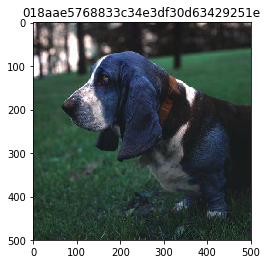

In [83]:
#print(df_train_small[df_train_small['id'] == '2cb1a35c9a986633dcc2c7289bafb02e'])
basset = dog_encoding('018aae5768833c34e3df30d63429251e', doggie_encoding_model)


For sanity check:
    
Select a basset and a collie from the training set
Select a basset from the dev set

./input/train-2/2102caf5ab229e2d6e621ceff6313ae1.jpg


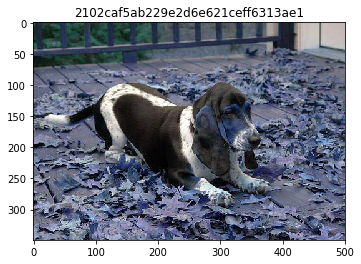

basset basset2
0.00041130252393513155
./input/train-2/4fc628e8fbd164b2e35f616af5cc8f41.jpg


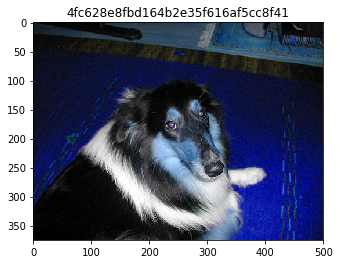

basset collie
0.0010445505148967012
From Dev Set
./input/train-2/dd5a3c84fb3c388ecf0b4da61eaef352.jpg


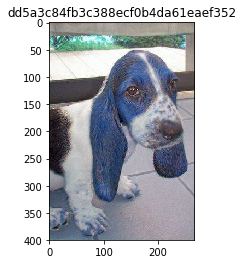

0.0003694227411251683
./input/train-2/da78fe89c55869ac6d1e1bbbd62c72c6.jpg


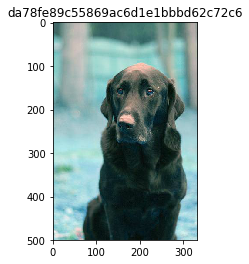

0.0013974258616892253
./input/train-2/f3c645a41e15598e326c368253d0703f.jpg


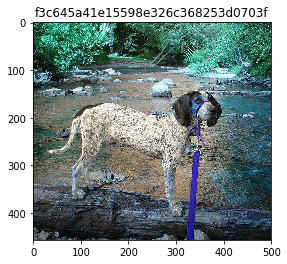

baset bluetick
0.0008647679490515354
./input/train-2/f9dece751a4afe2330c02007681a7f81.jpg


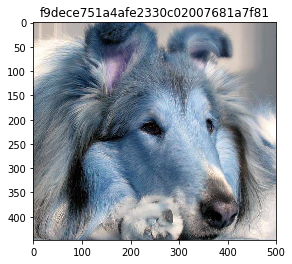

collie collie2
0.0003441950607438498
collie lab
0.0014296754937460905
collie bluetick
0.0010700440978370883


In [84]:
basset2 = dog_encoding('2102caf5ab229e2d6e621ceff6313ae1', doggie_encoding_model)
print('basset basset2')
print_distance(basset, basset2)

collie = dog_encoding('4fc628e8fbd164b2e35f616af5cc8f41', doggie_encoding_model)
print('basset collie')
print_distance(basset, collie)

#use dogs from Dev Set
print('From Dev Set')
basset3 = dog_encoding('dd5a3c84fb3c388ecf0b4da61eaef352', doggie_encoding_model)
print_distance(basset, basset3)

lab = dog_encoding('da78fe89c55869ac6d1e1bbbd62c72c6', doggie_encoding_model)
print_distance(basset, lab)

bluetick = dog_encoding('f3c645a41e15598e326c368253d0703f', doggie_encoding_model)

print('baset bluetick')
print_distance(basset, bluetick)

collie2 = dog_encoding('f9dece751a4afe2330c02007681a7f81', doggie_encoding_model)

print('collie collie2')
print_distance(collie, collie2)
print('collie lab')
print_distance(collie, lab)
print('collie bluetick')
print_distance(collie, bluetick)
